<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/v1_OneHot_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-Hot Encoded Feature Pipeline

### Observations
1. When I compare results of my pipeline with ensemble code from ```prakriti_MHCglobe_code_validation/_recompilation.ipynb```, it shows that training is not a deterministic process, even with the same X_tr, X_es, Y_tr, Y_es!

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 902, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 902 (delta 210), reused 287 (delta 156), pack-reused 549
Receiving objects: 100% (902/902), 125.77 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Updating files: 100% (204/204), done.


In [2]:
import numpy as np
import pandas as pd
import joblib as jb
import json
import tensorflow as tf

import os
import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import mhc_data
import inequality_loss
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install neptune
import neptune
from neptune.types import File

from google.colab import userdata
NEPTUNE_API_TOKEN = userdata.get('NEPTUNE_API_TOKEN')

In [ ]:
# Neptune
run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    tags = ["OneHot", "model_3", "80/20", "seed=27"],
)

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-32


#### In case you have to access a previous run

In [ ]:
project = "ppaul/MHC-BERT"
with_id = ""

In [ ]:
run = neptune.init_run(project=project,
    api_token=NEPTUNE_API_TOKEN,
    with_id=with_id,
)

## Get data
Contains both BA+EL, human and non-human

In [3]:
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data

#### Only human data

In [4]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]

### If 80 HLA train/20 HLA test

In [ ]:
# 542495, 135529
human_training_data, human_testing_data = trainf.BalanceSplitData().get_train_val(human_pMHC_data)

human_pMHC_data_train = human_training_data[[col for col in human_training_data.columns if col != 'test']]
human_pMHC_data_test = human_testing_data[[col for col in human_testing_data.columns if col != 'test']]

In [ ]:
training_data = human_pMHC_data_train.reset_index(drop=True)
testing_data = human_pMHC_data_test.reset_index(drop=True)

### If HLA+non-HLA train/100 test.

#### If Eric's Example

In [ ]:
# Eric Data
example_binding_data = '/content/mhcglobe/example/example_binding_data.csv'
human_pMHC_data_test = pd.read_csv(example_binding_data)

#### If user-set random

In [5]:
# 100 random samples
random_state = 428364
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=random_state)

#### If custom
e.g. want 100 test samples to be 95% ='s

In [ ]:
# 89529
human_pMHC_data_equals = human_pMHC_data[human_pMHC_data["measurement_inequality"] == "="]
# 588495
not_human_pMHC_data_equals = human_pMHC_data[human_pMHC_data["measurement_inequality"] != "="]

In [ ]:
not_human_pMHC_data_equals.shape

(588495, 9)

In [ ]:
random_state = 428364
human_pMHC_data_test_95 = human_pMHC_data_equals.sample(95, random_state=random_state)
human_pMHC_data_test_5 = not_human_pMHC_data_equals.sample(5, random_state=random_state)
human_pMHC_data_test = pd.concat([human_pMHC_data_test_95, human_pMHC_data_test_5])

#### Make Training Data

In [6]:
# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

In [7]:
training_data = pMHC_data_train.reset_index(drop=True)
testing_data = human_pMHC_data_test.reset_index(drop=True)

#### Or, upload data (in the case of perfect comparison between 2 models)!

In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/OneHot_24_04_10_model3/all_columns_pMHC_data_train_95=_24_04_10_run1_model3.csv")
testing_data = pd.read_csv("/content/drive/MyDrive/OneHot_24_04_10_model3/all_columns_human_pMHC_data_95=_24_04_10_run1_model3.csv")

### Visualize the Data

In [8]:
training_data.head(5)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True


In [9]:
testing_data.head(5)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True


### Make csv's that have all columns + save in Neptune

In [10]:
data_dir = "/content/mhcglobe/example/"
training_data_csv_name = data_dir + "all_columns_train_seed-428364_24_05_08.csv"
testing_data_csv_name = data_dir + "all_columns_test_seed-428364_24_05_08.csv"

In [11]:
training_data.to_csv(training_data_csv_name, index=False)
testing_data.to_csv(testing_data_csv_name, index=False)

## BUG IDK WHY WRONG ALL_COLUMNS_TEST AND TRAIN ARE IN NEPTUNE

In [ ]:
# Neptune
run_name_1, run_name_2 = "data/all_columns_training", "data/all_columns_testing"

In [ ]:
run[run_name_1].upload(training_data_csv_name)
run[run_name_2].upload(testing_data_csv_name)

#### Get 4 relevant columns

In [12]:
training_data = training_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]
testing_data = testing_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [13]:
training_data.head(5)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000


In [14]:
testing_data.head(5)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0


### Balance the dataset to get X_tr, Y_tr, X_es, Y_es!


In [15]:
# Returns a data frame with cols
# test (is it es or not), allele, peptide, measurement_inequality, measurement_value
train, es = trainf.BalanceSplitData().get_train_val(training_data)
# reset indices to prevent downstream issues
# 583650
train = train.reset_index(drop=True)
# 145788
es = es.reset_index(drop=True)

#### Or, upload data!

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/OneHot_24_04_10_model3/train_OneHot_95=_24_04_10_run1_model3.csv")
es = pd.read_csv("/content/drive/MyDrive/OneHot_24_04_10_model3/es_OneHot_95=_24_04_10_run1_model3.csv")

In [16]:
train.head(5)

,test,allele,peptide,measurement_inequality,measurement_value
0,False,HLA-B*08:01,ATGFKQSSKAL,=,3600.0
1,False,HLA-B*08:01,LTINKEEAL,=,1900.0
2,False,HLA-B*08:01,HPNIEEVAL,=,36000.0
3,False,HLA-B*08:01,ATDALMTGY,=,64700.0
4,False,HLA-B*08:01,RDWAHNSL,=,83400.0


In [17]:
es.head(5)

,test,allele,peptide,measurement_inequality,measurement_value
0,True,HLA-B*08:01,HPALVFDITK,=,52100.0
1,True,HLA-B*08:01,HSNIEEVAL,=,77800.0
2,True,HLA-B*08:01,RPALVFDITK,=,49800.0
3,True,HLA-B*08:01,HSKRKCDEL,=,77600.0
4,True,HLA-B*08:01,KSYEHQTPF,=,14415.0


#### Save these!

In [18]:
train_csv_name = "/content/mhcglobe/example/train_seed-428364_24_05_08.csv"
es_csv_name = "/content/mhcglobe/example/es_seed-428364_24_05_08.csv"

In [19]:
train.to_csv(train_csv_name, index=False)
es.to_csv(es_csv_name, index=False)

In [ ]:
# Neptune
run_name_1, run_name_2 = "data/train_OneHot_8020_model3_24_04_10", "data/es_OneHot_8020_model3_24_04_10"

In [ ]:
run[run_name_1].upload(train_csv_name)
run[run_name_2].upload(es_csv_name)

## Get One-Hot Encoded Features

In [20]:
X_tr, Y_tr = seqf.get_XY(
    train,
    encode_type="ONE_HOT",
    get_Y=True)

X_es, Y_es = seqf.get_XY(
    es,
    encode_type="ONE_HOT",
    get_Y=True)

## Pickle

In [30]:
import pickle
import json

my_data = {"X_tr": X_tr, "Y_tr": Y_tr, "X_es": X_es, "Y_es": Y_es}
with open('/content/drive/MyDrive/OneHot_train_es_encodings.pkl', 'wb') as f:
    pickle.dump(my_data, f)

## Load a Model

In [21]:
# This path doesn't matter because it never gets used.
new_mhcglobe_path = "/content/mhcglobe/example/"
init_ensemble = mhcglobe.ensemble(train_type='init', new_mhcglobe_path=new_mhcglobe_path)

model_3 = init_ensemble.ensemble_base_models[2]
# model_1 = init_ensemble.ensemble_base_models[0]

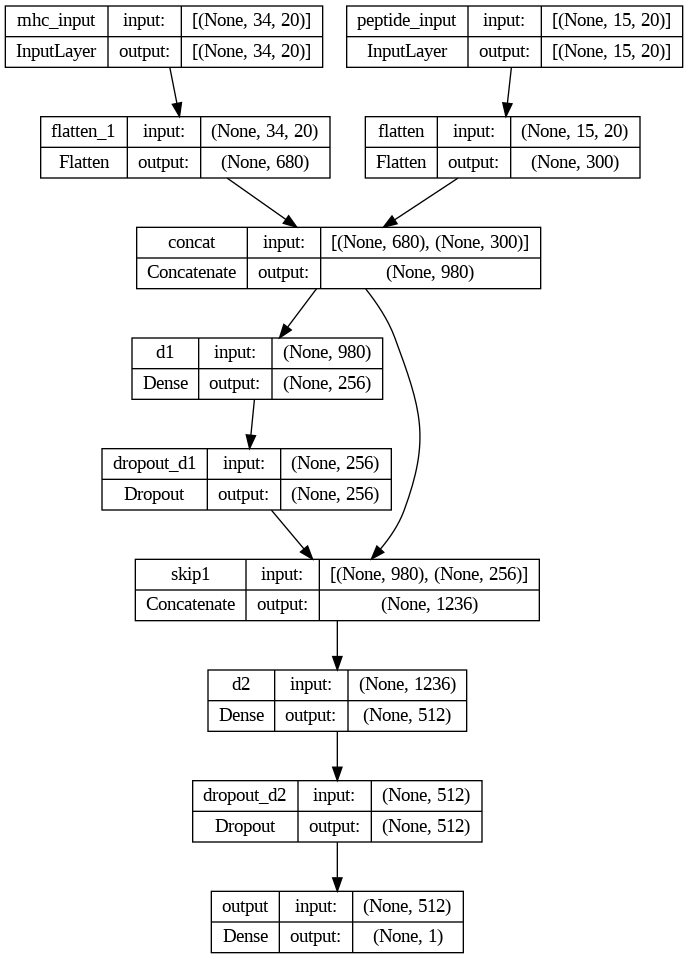

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, to_file='model_1.png', show_shapes=True, show_layer_names=True)

## Recompile Model with New Metrics

### First get the metrics

In [ ]:
print(model_3.optimizer, "\n")
print(model_3.optimizer.learning_rate, "\n")
print(model_3.optimizer.epsilon, "\n")
print(model_3.optimizer.momentum, "\n")
print(model_3.optimizer.centered, "\n")


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0019147476> 

3.17051703095139e-07 

<tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.5> 

True 



In [24]:
# Neptune - hardcoded from above
model_3_optimizer_params = {"optimizer_type": "RMSprop",
                            "learning_rate": 0.0019147476,
                            "momentum": 0.5,
                            "epsilon": 3.17051703095139e-07,
                            "centered": True}

# model_1_optimizer_params = {"optimizer_type": "RMSprop",
#                             "learning_rate": 0.0011339304,
#                             "momentum": 0.5,
#                             "epsilon": 6.848580326162904e-07,
#                             "centered": True}

# run["model/optimizer_params"] = model_3_optimizer_params
# run["model/optimizer_params"] = model_1_optimizer_params

In [25]:
from tensorflow.keras import optimizers, losses

optimizer = optimizers.RMSprop(
    learning_rate=model_3_optimizer_params["learning_rate"],
    momentum=model_3_optimizer_params["momentum"],
    epsilon=model_3_optimizer_params["epsilon"],
    centered=model_3_optimizer_params["centered"])

In [26]:
# Neptune
model_3_compiler_params = {"optimizer": "RMSprop",
                           "loss": "inequality_loss.MSEWithInequalities().loss",
                           "metrics": ["mean_absolute_error", "mean_squared_error", "root_mean_squared_error"]}

# Converts list into correct format.
# model_3_compiler_params["metrics"] = json.dumps(model_3_compiler_params["metrics"])
# # run["model/compiler_params"] = model_3_compiler_params

### Re-Compile
to get additional metrics

In [27]:
# swtich model_3 with model_1
model_3.compile(
    optimizer=model_3.optimizer,  # Use the same optimizer
    loss=model_3.loss,  # Use the same loss function
    metrics=["mean_absolute_error", "mean_squared_error", phf.root_mean_squared_error]  # These new ones get added to the old!
)

## Train the Model

In [ ]:
# Neptune
training_specs = {"batch_size": 10000,
                  "epochs": 300,
                  "shuffle": True,
                  "verbose": 1,
                  "mhc_callbacks": ["monitor=val_loss", "patience=20", "mode=min", "baseline=1", "min_delta=0.0001"],
                  "early_stopping": True,
                  "num_training_samples": 5000,
                  "num_es_samples": 5000}

# Converts list into correct format.
training_specs["mhc_callbacks"] = json.dumps(training_specs["mhc_callbacks"])

# Neptune
run["training/training_specs"] = training_specs

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as Callbacks

mhcglobe_callbacks = [Callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min',
                baseline=1,
                min_delta=0.0001)]

In [32]:
# swtich model_3 with model_1
verbose = 1
history = model_3.fit(X_tr, Y_tr,
                        batch_size= 10000, #hparams['batch_size'], 10000
                        epochs=300,
                        validation_data=(X_es, Y_es),
                        shuffle=True,
                        verbose=verbose,
                        callbacks=mhcglobe_callbacks)

Epoch 1/300
59/59 [==============================] - 5s 39ms/step - loss: 0.0352 - mean_absolute_error: 0.1293 - mean_squared_error: 0.0352 - root_mean_squared_error: 0.1828 - val_loss: 0.0270 - val_mean_absolute_error: 0.1058 - val_mean_squared_error: 0.0270 - val_root_mean_squared_error: 0.1617
Epoch 2/300
59/59 [==============================] - 1s 19ms/step - loss: 0.0264 - mean_absolute_error: 0.1081 - mean_squared_error: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0235 - val_mean_absolute_error: 0.0970 - val_mean_squared_error: 0.0235 - val_root_mean_squared_error: 0.1515
Epoch 3/300
59/59 [==============================] - 1s 19ms/step - loss: 0.0237 - mean_absolute_error: 0.1011 - mean_squared_error: 0.0237 - root_mean_squared_error: 0.1540 - val_loss: 0.0212 - val_mean_absolute_error: 0.0933 - val_mean_squared_error: 0.0212 - val_root_mean_squared_error: 0.1442
Epoch 4/300
59/59 [==============================] - 1s 19ms/step - loss: 0.0218 - mean_absolute_error: 0.

### Pickle history

In [35]:
my_data = {"history": history}
with open('/content/drive/MyDrive/history_seed-428364_24_05_08.pkl', 'wb') as f:
    pickle.dump(my_data, f)

### Save with Neptune!

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

In [ ]:
for i in range(len(loss)):
    run["training/loss"].append(loss[i])
    run["training/val_loss"].append(val_loss[i])
    run["training/mae"].append(mae[i])
    run["training/val_mae"].append(val_mae[i])
    run["training/mse"].append(mse[i])
    run["training/val_mse"].append(val_mse[i])
    run["training/rmse"].append(rmse[i])
    run["training/val_rmse"].append(val_rmse[i])

## Predict using this model!!!

In [34]:
test_X, test_Y = seqf.get_XY(testing_data, encode_type="ONE_HOT", get_Y=True)

### First pickle

In [36]:
my_data = {"test_X": test_X, "test_Y": test_Y}
with open('/content/drive/MyDrive/OneHot_test_encodings.pkl', 'wb') as f:
    pickle.dump(my_data, f)

In [37]:
test_predictions = model_3.predict(test_X)

4/4 [==============================] - 0s 11ms/step


In [38]:
prediction_df = phf.get_prediction_df(model_3, test_X, testing_data)

4/4 [==============================] - 0s 2ms/step


In [39]:
prediction_df

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,93.754056,0.580336
1,HLA-B*27:05,TRYQTFVNF,<,100.0,103.287838,0.571385
2,HLA-A*02:12,AARHKHQVM,>,20000.0,47619.441520,0.004509
3,HLA-B*07:02,IPRSILMTTF,<,100.0,71.446825,0.605449
4,HLA-B*27:05,SRVMDFFRR,<,100.0,107.719812,0.567502
...,...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,104.045710,0.570709
96,HLA-A*11:01,ALERLLSLKK,=,822.0,144.246620,0.540515
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,102.279106,0.572292
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,102.461386,0.572127


### Pickle predictions

In [40]:
my_data = {"prediction_df": prediction_df}
with open('/content/drive/MyDrive/prediction_df_seed-428364_24_05_08.pkl', 'wb') as f:
    pickle.dump(my_data, f)

### Rewrite code but use below chunk so I can save the figure in Neptune!

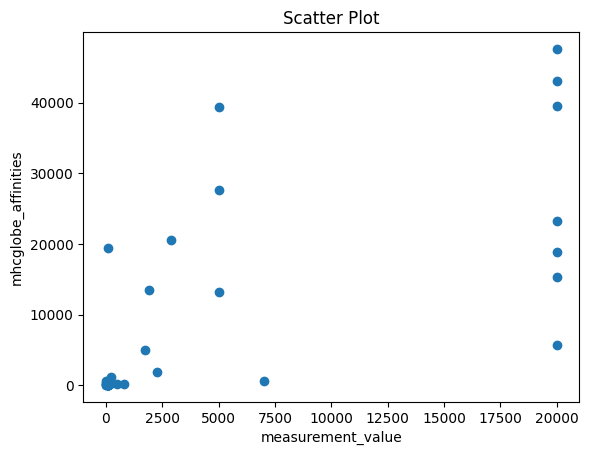

In [43]:
scatter_plot = phf.make_scatter_plot(prediction_df, "measurement_value", "mhcglobe_affinities", "Scatter Plot Model 3, Seed = 428364", ".")

In [44]:
predictions_r, predictions_mse = phf.get_r_squared_mse(prediction_df, "measurement_value", "mhcglobe_affinities")
print("R-squared:", predictions_r)
print("MSE:", predictions_mse)

R-squared: 0.5853174872093316
MSE: 45498628.49222919


In [45]:
my_data = {"R-squared": predictions_r, "MSE": predictions_mse}
with open('/content/drive/MyDrive/results_seed-428364_24_05_08.pkl', 'wb') as f:
    pickle.dump(my_data, f)

In [ ]:
# Neptune
savefig_name = "scatter_plot_OneHot_95=_24_04_10_run1_model3.png"

run["testing/r_squared"] = predictions_r
run["testing/mse"] = predictions_mse
run["testing/scatter_plot"].upload((savefig_name))

### Save the Predictions

In [ ]:
# Neptune
run["testing/OneHot_test_predictions_OneHot_8020_model_3_24_04_10"].upload(File.as_pickle(test_predictions))
run["testing/OneHot_all_prediction_df_OneHot_8020_model_3_24_04_10"].upload(File.as_pickle(prediction_df))

In [ ]:
# Neptune
run["testing/OneHot_all_prediction_df_OneHot_8020_model_3_24_04_10"].upload(File.as_html(prediction_df))

#### Take a Note

In [ ]:
run["note"] = "80/20 HLA prediction is terrible"

## Set up Model

In [ ]:
key = "THREE2"

model = neptune.init_model(
    project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    key=key
)

In [ ]:
# Training related
model["run_id"] = run["sys/id"].fetch()
model["num_training_samples"] = train.shape[0]
model["num_es_samples"] = es.shape[0]
model["model/model_3_tf_graph"].upload("/content/model_3.png")
model["optimizer_params"] = model_3_optimizer_params
model["compiler_params"] = model_3_compiler_params

# Testing related
model["r_squared"] = predictions_r
model["mse"] = predictions_mse
model["scatter_plot"].upload((savefig_name))

### Or make a version

In [ ]:
model_version = neptune.init_model_version(
    project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    model="MHCBER-ONEHOT",
)

In [ ]:
model["note"] = "Not as good on a random sample of 100!"
# model_version["note"] = "Travesty whe I train and test on human!!!"

In [ ]:
# Training related
model_version["run_id"] = run["sys/id"].fetch()
model_version["num_training_samples"] = train.shape[0]
model_version["num_es_samples"] = es.shape[0]
model_version["model/model_3_tf_graph"].upload("/content/model_3.png")
model_version["optimizer_params"] = model_3_optimizer_params
model_version["compiler_params"] = model_3_compiler_params

# Testing related
model_version["r_squared"] = predictions_r
model_version["mse"] = predictions_mse
model_version["scatter_plot"].upload((savefig_name))

In [ ]:
run.stop()
# model.stop()
# model_version.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-30/metadata
